In [34]:
import pandas as pd
import os

from pathlib import Path

In [35]:
r_paths = {
    "train": Path("./results_train_m4_final/"),
    "val": Path("./results_val_m4_final/")
}

In [36]:
d = {}

for partition, r_path in r_paths.items():
    d[partition] = {}
    for seq in os.listdir(r_path):
        if (r_path / seq).is_dir():
            d[partition][seq] = {}
            for prop in os.listdir(r_path / seq):
                if not prop.endswith("summary.csv"):
                    r_type = None
                    if "pred" in prop:
                        prop_name = prop.split("_pred")[0]
                        prop_path = prop
                        r_type = "pred"
                    else:
                        prop_name = prop.split("_gt")[0]
                        prop_path = '_'.join(prop.split("_")[:2]) + "_gt.csv" if not ("vehicle" in prop or "bicycle" in prop or "person" in prop) else prop
                        r_type = "gt"
                    
                    if prop_name in d[partition][seq]:
                        d[partition][seq][prop_name][r_type] = r_path / seq / prop_path
                    else:
                        d[partition][seq][prop_name] = {r_type: r_path / seq / prop_path}

In [8]:
def retrieve_extra_data(df, idx):
    propositions_names = df.keys()[4:7]
    f0_d = {
            "image_path":df["img_path"][idx-1],
            "speed":df["speed"][idx-1], 
            "acc":df["acc"][idx-1]
        }
    f1_d = {
            "image_path":df["img_path"][idx],
            "speed":df["speed"][idx], 
            "acc":df["acc"][idx]
        }
    for proposition_name in propositions_names:
        f0_d[proposition_name] = df[proposition_name][idx-1]
        f1_d[proposition_name] = df[proposition_name][idx]

    extra_data = {
        "frame_0": f0_d,
        "frame_1": f1_d
    }

    return extra_data

In [9]:
def get_confusion_matrix(filter, d, partitions):
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    speed15_counts = 0
    speed25_counts = 0
    speed35_counts = 0
    speed45_counts = 0

    extra_data = {}

    for partition in partitions:
        for seq_key, seq_val in d[partition].items():
            for prop_key, prop_val in seq_val.items():
                if prop_key in filter:
                    df_gt = pd.read_csv(prop_val["gt"])
                    df_pred = pd.read_csv(prop_val["pred"])
                    true_neg_flag = True
                    false_flag = True
                    speed15 = False
                    speed25 = False
                    speed35 = False
                    speed45 = False
                    for idx, (gt, pred) in enumerate(zip(df_gt["property"], df_pred["property"])):
                        if gt != pred:
                            # False Negative
                            if gt == False:
                                fn += 1
                                print(f"FN: Partition {partition} | Seq {seq_key} | {idx} | {df_gt['img_path'][idx]}")
                                extra_data[f"fn_{partition}_{seq_key}"] = {
                                    "gt": retrieve_extra_data(df_gt, idx),
                                    "pred": retrieve_extra_data(df_pred, idx)
                                }
                            # False Positive
                            else:
                                fp += 1
                                print(f"FP: Partition {partition} | Seq {seq_key} | {idx} | {df_gt['img_path'][idx]}")
                                extra_data[f"fp_{partition}_{seq_key}"] = {
                                    "gt": retrieve_extra_data(df_gt, idx),
                                    "pred": retrieve_extra_data(df_pred, idx)
                                }
                            false_flag = False
                            break
                        else:
                            # True Negative
                            if gt == True:
                                if prop_key == "Phi0_base":
                                    if df_gt["speed"][idx] >= 15:
                                        speed15 = True
                                if prop_key == "Phi1_base":
                                    if df_gt["speed"][idx] >= 25:
                                        speed25 = True
                                if prop_key == "Phi2_base":
                                    if df_gt["speed"][idx] >= 35:
                                        speed35 = True
                                if prop_key == "Phi3_base":
                                    if df_gt["speed"][idx] >= 45:
                                        speed45 = True
                                continue
                            # True positive
                            else:
                                true_neg_flag = False
                                break
                    if false_flag:
                        if true_neg_flag:
                            tn += 1
                        else:
                            print(f"TP: Partition {partition} | Seq {seq_key} | {idx} | {df_gt['img_path'][idx]}")
                            extra_data[f"tp_{partition}_{seq_key}"] = {
                                "gt": retrieve_extra_data(df_gt, idx),
                                "pred": retrieve_extra_data(df_pred, idx)
                            }
                            tp += 1
                    if prop_key == "Phi0_base":
                        if speed15:
                            speed15_counts += 1
                    if prop_key == "Phi1_base":
                        if speed25:
                            speed25_counts += 1
                    if prop_key == "Phi2_base":
                        if speed35:
                            speed35_counts += 1
                    if prop_key == "Phi3_base":
                        if speed45:
                            speed45_counts += 1

    print(tp,fp)
    print(fn,tn)
    return tp,fp,fn,tn, extra_data, speed15_counts, speed25_counts, speed35_counts, speed45_counts

# Threshold properties

In [10]:
tp,fp,fn,tn, extra_data_phi0,speed15_counts,_,_,_ = get_confusion_matrix(["Phi0_base"],d,["train","val"])   # vehicle, bicycle, person
print(speed15_counts)

TP: Partition train | Seq seq_140 | 38 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_154167.jpg
TP: Partition train | Seq seq_156 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_157299.jpg
TP: Partition train | Seq seq_141 | 39 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_154367.jpg
TP: Partition train | Seq seq_123 | 62 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_150822.jpg
TP: Partition train | Seq seq_126 | 2 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_151357.jpg
FP: Partition train | Seq seq_39 | 37 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_134163.jpg
TP: Partition train | Seq seq_122 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_150562.jpg
TP: Partition train | Seq seq_3 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_126985.jpg
TP: Partition train | Seq seq_43 | 106 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_135026.jpg

In [15]:
tp,fp,fn,tn, extra_data_phi1,_,speed25_counts,_,_ = get_confusion_matrix(["Phi1_base"],d,["train","val"])   # vehicle, bicycle, person
print(speed25_counts)

FN: Partition train | Seq seq_156 | 61 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_157359.jpg
TP: Partition train | Seq seq_39 | 140 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_134266.jpg
TP: Partition train | Seq seq_122 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_150562.jpg
TP: Partition train | Seq seq_63 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_138882.jpg
TP: Partition train | Seq seq_96 | 2 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_145419.jpg
FN: Partition train | Seq seq_35 | 55 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_133389.jpg
TP: Partition train | Seq seq_30 | 35 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_132377.jpg
TP: Partition train | Seq seq_84 | 144 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_143175.jpg
TP: Partition train | Seq seq_49 | 93 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_136202.jpg


In [16]:
tp,fp,fn,tn, extra_data_phi2,_,_,speed35_counts,_ = get_confusion_matrix(["Phi2_base"],d,["train","val"])   # vehicle, bicycle, person
print(speed35_counts)

TP: Partition train | Seq seq_156 | 61 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_157359.jpg
TP: Partition train | Seq seq_63 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_138882.jpg
FP: Partition train | Seq seq_96 | 14 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_145431.jpg
TP: Partition train | Seq seq_49 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_136110.jpg
FN: Partition train | Seq seq_99 | 69 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_146080.jpg
TP: Partition train | Seq seq_113 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_148791.jpg
TP: Partition train | Seq seq_121 | 82 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_150446.jpg
FP: Partition train | Seq seq_139 | 93 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_154025.jpg
TP: Partition train | Seq seq_75 | 7 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_141254.jpg
T

In [17]:
tp,fp,fn,tn, extra_data_phi3,_,_,_,speed45_counts = get_confusion_matrix(["Phi3_base"],d,["train","val"])   # vehicle, bicycle, person
print(speed45_counts)

TP: Partition train | Seq seq_63 | 30 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_138911.jpg
TP: Partition train | Seq seq_96 | 15 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_145432.jpg
TP: Partition train | Seq seq_49 | 15 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_136124.jpg
TP: Partition train | Seq seq_99 | 169 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_146180.jpg


TP: Partition train | Seq seq_113 | 14 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_148804.jpg
TP: Partition train | Seq seq_75 | 1 | /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_141248.jpg
6 0
0 193
10


# Violations analysis

In [12]:
from PIL import Image
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

In [13]:
def plot_images(r_type: str, extra_data, figsize=(10, 5)):
    for r in extra_data.keys():
        if r.startswith(r_type):
            # Load the images using PIL
            image_0 = Image.open(extra_data[r]['gt']['frame_0']['image_path'])
            image_1 = Image.open(extra_data[r]['gt']['frame_1']['image_path'])
            
            # Plot the images side by side using matplotlib
            fig, axes = plt.subplots(1, 2, figsize=figsize)

            axes[0].imshow(image_0)
            axes[0].set_title('Frame 0')
            axes[0].axis('off')

            axes[1].imshow(image_1)
            axes[1].set_title('Frame 1')
            axes[1].axis('off')

            plt.show()

            # Display the information below the images
            display(Markdown(f"## ID: {r}"))
            display(Markdown("### FRAME 0"))
            display(Markdown(f"**Img path:** {extra_data[r]['gt']['frame_0']['image_path']}"))
            display(Markdown(f"**Speed:** {extra_data[r]['gt']['frame_0']['speed']} | **Acc:** {extra_data[r]['gt']['frame_0']['acc']}"))
            display(Markdown("**GT**"))
            for proposition_name in list(extra_data[r]['gt']['frame_0'].keys())[-3:]:
                display(Markdown(f"{proposition_name}: {extra_data[r]['gt']['frame_0'][proposition_name]}"))
            display(Markdown("**PRED**"))
            for proposition_name in list(extra_data[r]['pred']['frame_0'].keys())[-3:]:
                display(Markdown(f"{proposition_name}: {extra_data[r]['pred']['frame_0'][proposition_name]}"))

            display(Markdown("### FRAME 1"))
            display(Markdown(f"**Img path:** {extra_data[r]['gt']['frame_1']['image_path']}"))
            display(Markdown(f"**Speed:** {extra_data[r]['gt']['frame_1']['speed']} | **Acc:** {extra_data[r]['gt']['frame_1']['acc']}"))
            display(Markdown("**GT**"))
            for proposition_name in list(extra_data[r]['gt']['frame_1'].keys())[-3:]:
                display(Markdown(f"{proposition_name}: {extra_data[r]['gt']['frame_1'][proposition_name]}"))
            display(Markdown("**PRED**"))
            for proposition_name in list(extra_data[r]['pred']['frame_1'].keys())[-3:]:
                display(Markdown(f"{proposition_name}: {extra_data[r]['pred']['frame_1'][proposition_name]}"))

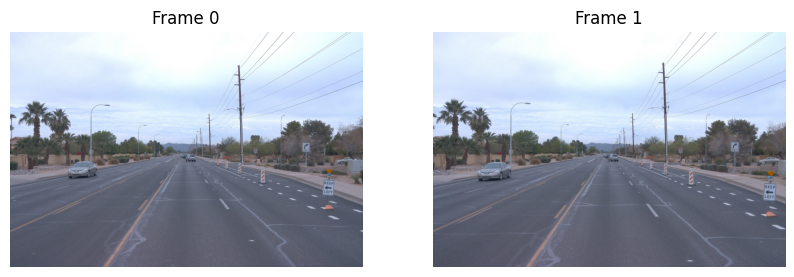

## ID: fn_train_seq_99

### FRAME 0

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_146079.jpg

**Speed:** 39.1 | **Acc:** 0.438

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: False

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

### FRAME 1

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_146080.jpg

**Speed:** 39.177 | **Acc:** 0.346

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

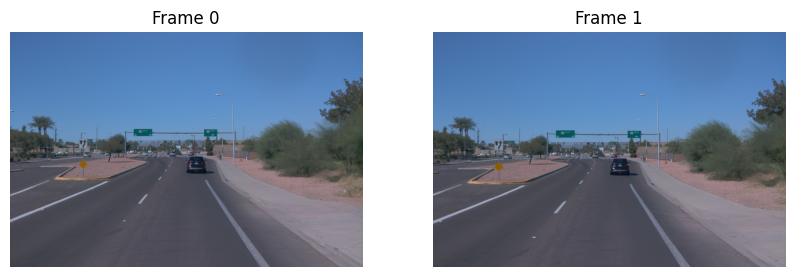

## ID: fn_val_seq_5

### FRAME 0

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/validation_uncompressed/img_32893.jpg

**Speed:** 43.238 | **Acc:** -0.637

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: False

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

### FRAME 1

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/validation_uncompressed/img_32894.jpg

**Speed:** 43.249 | **Acc:** 0.049

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: False

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

In [18]:
plot_images("fn", extra_data_phi2)

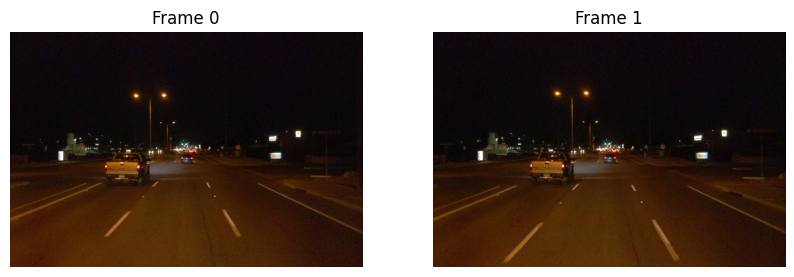

## ID: fp_train_seq_96

### FRAME 0

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_145430.jpg

**Speed:** 44.984 | **Acc:** 0.412

**GT**

is_vehicle_between_25_40m: False

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

### FRAME 1

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_145431.jpg

**Speed:** 45.038 | **Acc:** 0.239

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

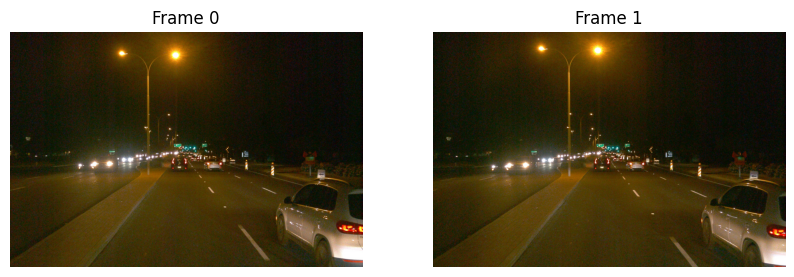

## ID: fp_train_seq_139

### FRAME 0

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_154024.jpg

**Speed:** 35.45 | **Acc:** 0.959

**GT**

is_vehicle_between_25_40m: False

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

### FRAME 1

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_154025.jpg

**Speed:** 35.7 | **Acc:** 1.118

**GT**

is_vehicle_between_25_40m: False

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

In [19]:
plot_images("fp", extra_data_phi2)

## Interesting cases

In [20]:
fn = "fn_val_seq_5"
tp = "tp_train_seq_49"

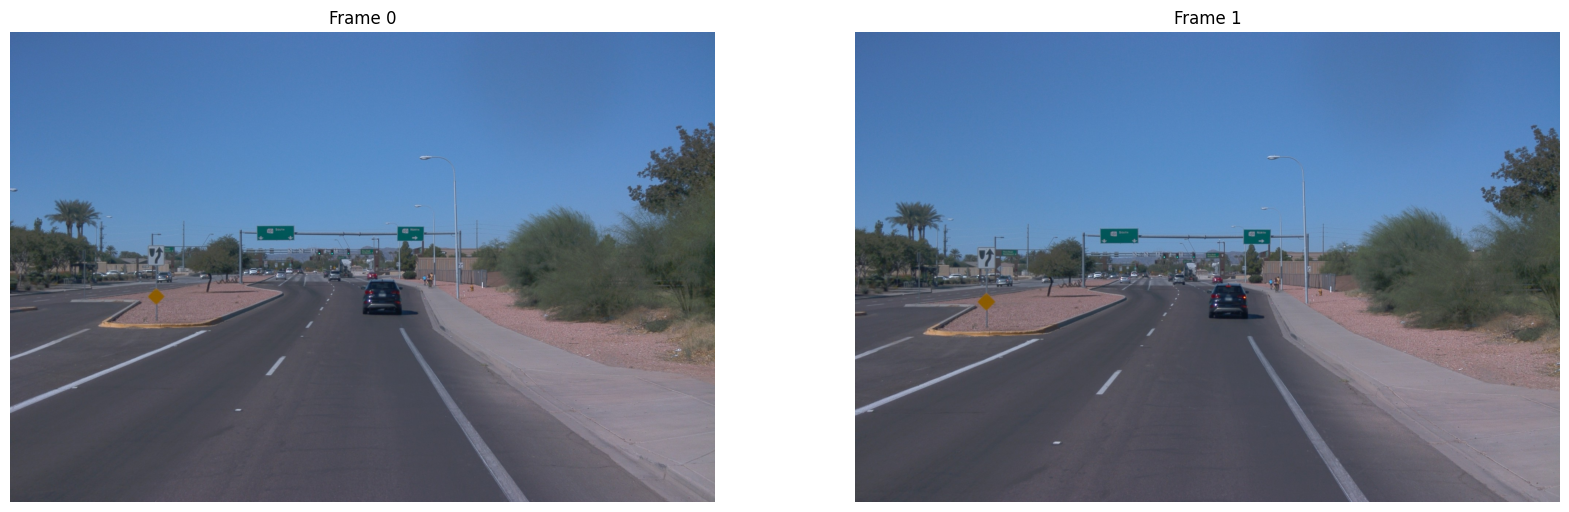

## ID: fn_val_seq_5

### FRAME 0

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/validation_uncompressed/img_32893.jpg

**Speed:** 43.238 | **Acc:** -0.637

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: False

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

### FRAME 1

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/validation_uncompressed/img_32894.jpg

**Speed:** 43.249 | **Acc:** 0.049

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: False

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

In [21]:
plot_images(fn, extra_data_phi2, figsize=(20,10))

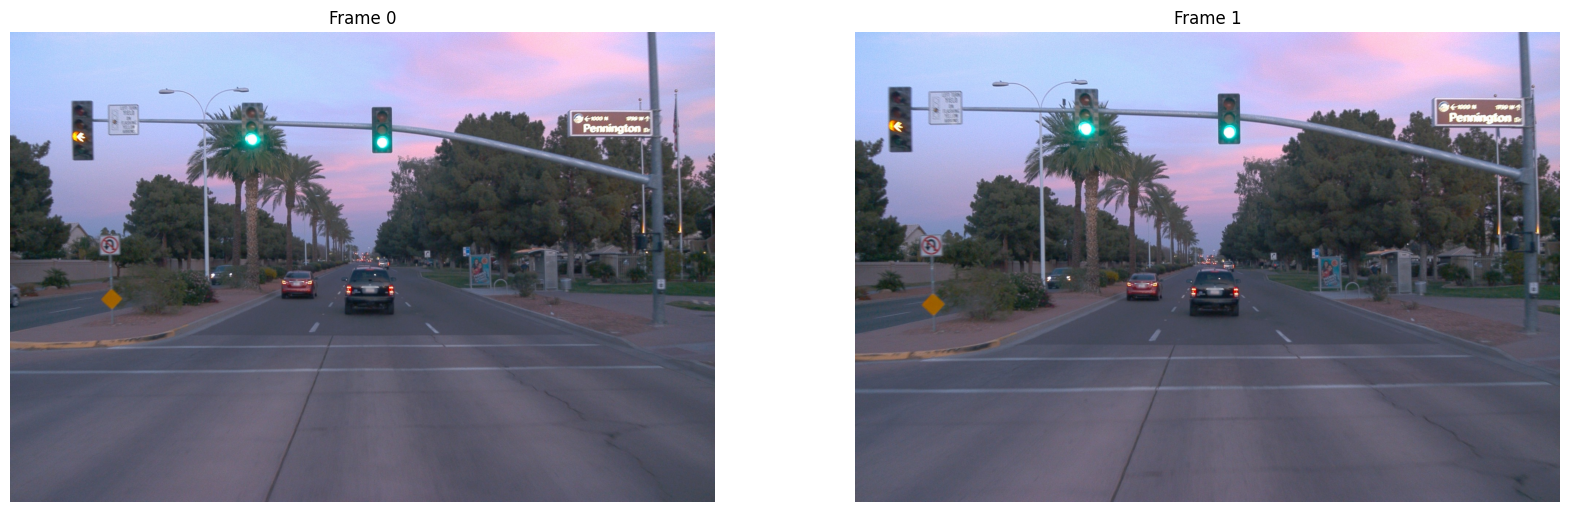

## ID: tp_train_seq_49

### FRAME 0

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_136109.jpg

**Speed:** 44.592 | **Acc:** 0.544

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

### FRAME 1

**Img path:** /scratch/ft8bn/datasets/waymo_1.4/training_uncompressed/img_136110.jpg

**Speed:** 44.823 | **Acc:** 1.035

**GT**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

**PRED**

is_vehicle_between_25_40m: True

is_bicycle_between_25_40m: False

is_person_between_25_40m: False

In [22]:
plot_images(tp, extra_data_phi2, figsize=(20,10))

# Sequences stats

In [23]:
filter = ["Phi1_base", "Phi2_base", "Phi3_base"]
partitions = ["train","val"]
attributes = {
    "is_vehicle_within_25m": 0, "is_bicycle_within_25m": 0, "is_person_within_25m": 0,
    "is_vehicle_between_25_40m": 0, "is_bicycle_between_25_40m": 0, "is_person_between_25_40m": 0,
    "is_vehicle_between_40_60m": 0, "is_bicycle_between_40_60m": 0, "is_person_between_40_60m": 0
}
attributes_pred = attributes.copy()

frame_count = 0
len_of_seq = []
for partition in partitions:
    for seq_key, seq_val in d[partition].items():
        seq_len = 0
        for prop_key, prop_val in seq_val.items():
            if prop_key in filter:
                df_gt = pd.read_csv(prop_val["gt"])
                for idx, row in df_gt.iterrows():
                    if prop_key == "Phi1_base":
                        frame_count += 1
                        seq_len += 1
                    for attr in attributes.keys():
                        if attr in row:
                            if row[attr] == True:
                                attributes[attr] += 1
                df_pred = pd.read_csv(prop_val["pred"])
                for idx, row in df_pred.iterrows():
                    for attr in attributes_pred.keys():
                        if attr in row:
                            if row[attr] == True:
                                attributes_pred[attr] += 1
        len_of_seq.append(seq_len)

In [24]:
attributes

{'is_vehicle_within_25m': 21227,
 'is_bicycle_within_25m': 682,
 'is_person_within_25m': 5751,
 'is_vehicle_between_25_40m': 22053,
 'is_bicycle_between_25_40m': 388,
 'is_person_between_25_40m': 7839,
 'is_vehicle_between_40_60m': 24286,
 'is_bicycle_between_40_60m': 628,
 'is_person_between_40_60m': 8437}

In [25]:
all_vehicles = (attributes["is_vehicle_within_25m"] + attributes["is_vehicle_between_25_40m"] + attributes["is_vehicle_between_40_60m"])
all_bicycles = (attributes["is_bicycle_within_25m"] + attributes["is_bicycle_between_25_40m"] + attributes["is_bicycle_between_40_60m"])
all_persons = (attributes["is_person_within_25m"] + attributes["is_person_between_25_40m"] + attributes["is_person_between_40_60m"])
print(all_vehicles)
print(all_bicycles)
print(all_persons)

67566
1698
22027


In [27]:
attributes_pred

{'is_vehicle_within_25m': 20882,
 'is_bicycle_within_25m': 664,
 'is_person_within_25m': 5847,
 'is_vehicle_between_25_40m': 22720,
 'is_bicycle_between_25_40m': 404,
 'is_person_between_25_40m': 7857,
 'is_vehicle_between_40_60m': 23910,
 'is_bicycle_between_40_60m': 624,
 'is_person_between_40_60m': 8391}

In [58]:
frame_count

39019

In [18]:
sum(len_of_seq) / len(len_of_seq)

196.0753768844221